In [26]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

# Functions

In [27]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.000001)


def train(sequence, label ,model ,optimizer ,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 



def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))

    return inps

def predcorr(mods, tests, plot_corr = True):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
    all_dfs1 = pd.concat(dfs1) 
    preds, labs = all_dfs1['pred'], all_dfs1['label']
    xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
    r2_val = r2_score(all_dfs1['pred'],all_dfs1['label'])
    df_fin = all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)
    if plot_corr:
        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_val, 2)) )
             
    return r2_val, df_fin, all_dfs1  

# -----------------
# Generating trials
# -----------------

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)
    
def heatmap_acc(num_inputs, df, ax):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    map_syms = total_syms[:num_inputs]
    data_accs = np.empty((num_inputs, num_inputs))
    data_accs[:] = np.NaN
    for r, trial in enumerate(df.index):
        i = map_syms.index(eval(trial)[0])
        j = map_syms.index(eval(trial)[2])
        acc = round(df.iloc[r]['acc'], 2)
        data_accs[i,j] = acc
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(num_inputs), labels=map_syms)
    ax.set_yticks(np.arange(num_inputs), labels=map_syms)

    #cmap = mpl.colors.ListedColormap(['yellow', 'orange', 'darkorange','red'])
    from matplotlib import cm
    new_reds = cm.get_cmap('Reds', 10)
    cmap=new_reds
    bounds = list(np.arange(0,1.1,0.1))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data_accs, cmap=cmap, norm=norm)

    # Loop over data dimensions and create text annotations.
    for i in range(num_inputs):
        for j in range(num_inputs):
            if np.isnan(data_accs[i, j]):
                pass
            else:
                text = ax.text(j,i, data_accs[i, j],
                              ha="center", va="center", color="black", fontsize=12)


# RNN setup

In [28]:
## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 

def fully_trained_rnns(res):

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
   
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:], 'test_acc': acc_test[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc = fully_trained.test_acc
    fully_trained_idx = fully_trained.index
    
    final_accs = pd.DataFrame({'train_acc': acc_train_p[-1,:], 'test_acc_p': acc_test_p[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc_p = fully_trained.test_acc_p
    fully_trained_idx_p = fully_trained.index
    
    ft_idx = list(fully_trained_idx_p.intersection(fully_trained_idx))
    
    ft_cue_dicts = [cue_dicts[i] for i in ft_idx]
    ft_tests = [tests[i] for i in ft_idx]
    ft_mods = [mods[i] for i in ft_idx]
    ft_mods_p = [mods_p[i] for i in ft_idx]
    
    return ft_mods, ft_mods_p, ft_tests, ft_cue_dicts, ft_test_acc, ft_test_acc_p 
    

def run_exp(trainseqs_old ,trainseqs_old_p, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old_p, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    model_p = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
    
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset,
           'loss_p':loss2, 'acc_p':acc2, 'mod_p': model_p}

def run_plot(trainseqs, trainseqs_p, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, trainseqs_p, testseqs, cue_dict) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
    
    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'no pretraining', shift = 0)
    plotNNs([losses_p], [acc_train_p, acc_test_p], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'with pretraining', shift = 0)
    
    acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_train_p': acc_train_p[-1,:],\
            'acc_test': acc_test[-1,:], 'acc_test_p': acc_test_p[-1,:]})
    
    return {'res':res, 'mods':mods, 'mods_p':mods_p, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df }


In [29]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

# Run RNN
Final accuracy against ratio of other/self



In [31]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms)
rp = generate_other_reverse_primitives('+', all_syms)
print(primitives)
print(rp)

{'A': 3, 'B': 5, 'C': 7, 'D': 11}
[['A', '=', 3], ['B', '=', 5], ['C', '=', 7], ['D', '=', 11]]
[['A', ('+', 'C'), '=', 10], ['B', ('+', 'D'), '=', 16]]


trainseqs  [['A', ('+', 'A'), '=', 6], ['A', ('+', 'B'), '=', 8], ['A', ('+', 'C'), '=', 10], ['A', ('+', 'D'), '=', 14], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 10], ['B', ('+', 'C'), '=', 12], ['B', ('+', 'D'), '=', 16], ['C', ('+', 'A'), '=', 10], ['C', ('+', 'B'), '=', 12], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 18], ['D', ('+', 'A'), '=', 14], ['D', ('+', 'B'), '=', 16], ['D', ('+', 'C'), '=', 18], ['D', ('+', 'D'), '=', 22]]
testseqs  [['A', ('+', 'A'), '=', 6], ['A', ('+', 'B'), '=', 8], ['A', ('+', 'C'), '=', 10], ['A', ('+', 'D'), '=', 14], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 10], ['B', ('+', 'C'), '=', 12], ['B', ('+', 'D'), '=', 16], ['C', ('+', 'A'), '=', 10], ['C', ('+', 'B'), '=', 12], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 18], ['D', ('+', 'A'), '=', 14], ['D', ('+', 'B'), '=', 16], ['D', ('+', 'C'), '=', 18], ['D', ('+', 'D'), '=', 22]]
run time:  220.6806470990181


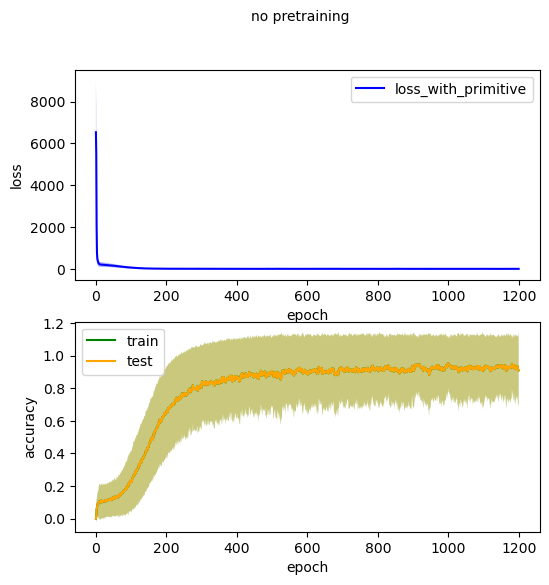

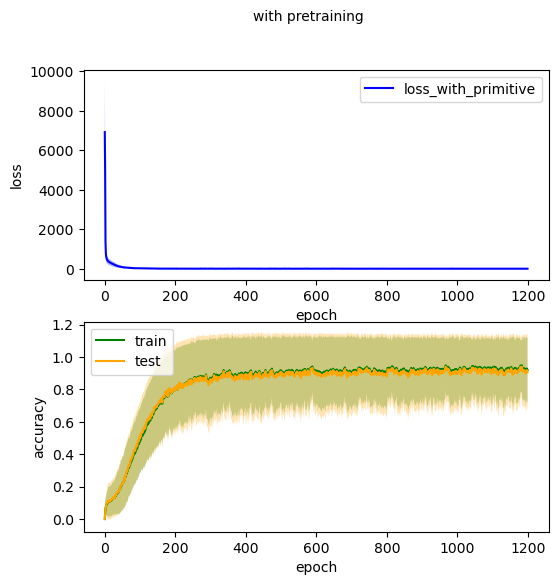

In [132]:
num_sims = 400
#trainseqs = generate_trials(ops, all_syms, all_syms) + generate_other_reverse_primitives('+', all_syms)
trainseqs = generate_trials(ops, all_syms, all_syms) 
trainseqs_p = generate_trials(ops, all_syms, all_syms) + primitives
testseqs = generate_trials(ops, all_syms, all_syms)
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, trainseqs_p, testseqs, cue_dict)

In [249]:
save_dir = '../results/representation_analysis/full/'

with open(save_dir+'res_full', 'wb') as f:
    pickle.dump(res1,f)

In [133]:
## find indices of 100% acc rnns
acc_df = res1['acc_df']
all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
len(all_acc_mods)

247

In [164]:
all_acc_mods[:5]

Int64Index([0, 8, 10, 12, 13], dtype='int64')

In [224]:
## calculate distance matrices for all models and steps 

mod_list = all_acc_mods
#mod_list = np.arange(num_sims)

# initialise empty lists/arrays
avg_dists = np.empty((len(mod_list),4))
avg_dists_p = np.empty((len(mod_list),4))
dms = [[] for _ in range(4)]
dms_p = [[] for _ in range(4)]

# extracts results from dictionary
mods = res1['mods']
mods_p = res1['mods_p']
cue_dicts = res1['cue_dicts']
testseq = generate_trials(ops, all_syms, all_syms)
ft_cue_dicts = [cue_dicts[j] for j in mod_list]

for ind, m in enumerate(mod_list): # for each model 
# for m in all_acc_mods:
    testseq = change_dict(testseq, cue_dicts[m])
    train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
    testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    # get activations for control model
    hiddens, trials = get_reps(mods[m], [testset], hidden_size)
    for h in range(4): 
        hid_val = np.array([hid[h,:] for hid in hiddens]) # combine activations from each context for the time step
        dm = euclidean_distances(hid_val) # calculate euclidean distance between contexts
        dms[h].append(dm)
        av = scipy.sparse.triu(dm).mean() # find mean distance between contexts from upper triangular matrix
        avg_dists[ind, h] = av
    # get activations for primitive trained model
    hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
    for h in range(4):
        hid_val = np.array([hid[h,:] for hid in hiddens_p])
        dm = euclidean_distances(hid_val)
        dms_p[h].append(dm)
        av = scipy.sparse.triu(dm).mean()
        avg_dists_p[ind, h] = av


# Analysis

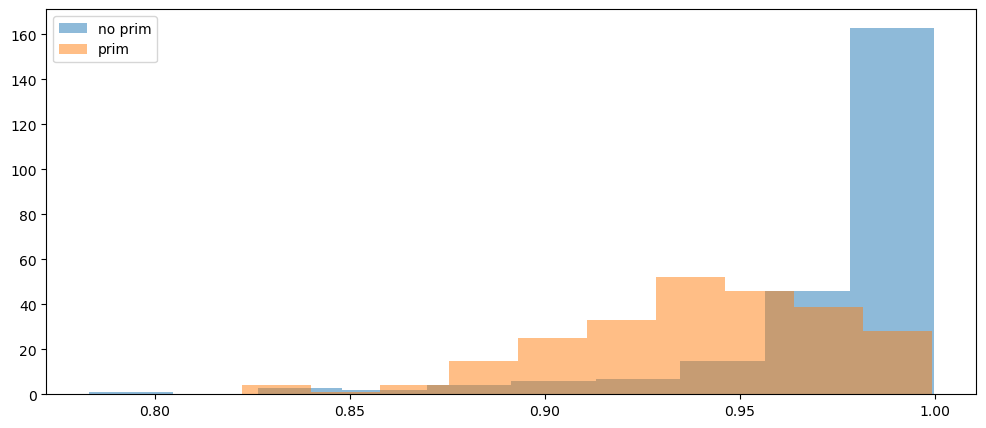

In [243]:
from sklearn.linear_model import LinearRegression
rs = []
for i, cd in enumerate(ft_cue_dicts):
    curr_tests = change_dict(testseqs, ft_cue_dicts[i])
    truth_outs = [t[-1] for t in curr_tests]
    truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
    x = dms[2][i].reshape(-1,1)
    y = truth_RDM.reshape(16*16)
    
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    rs.append(r_sq)

rs_p = []
for i, cd in enumerate(ft_cue_dicts):
    curr_tests = change_dict(testseqs, ft_cue_dicts[i])
    truth_outs = [t[-1] for t in curr_tests]
    truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
    x = dms_p[2][i].reshape(-1,1)
    y = truth_RDM.reshape(16*16)
    
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    rs_p.append(r_sq)

plt.hist(rs, alpha=0.5, label='no prim')
plt.hist(rs_p, alpha=0.5, label='prim')
plt.legend()

In [230]:
scipy.stats.wilcoxon(rs, rs_p)

WilcoxonResult(statistic=10761.0, pvalue=5.1072226102460093e-05)

In [248]:
np.sum(np.subtract(rs_p, rs) < 0)

213

In [236]:
scipy.stats.ttest_ind(rs, rs_p)

Ttest_indResult(statistic=0.03087841252388732, pvalue=0.9753790278031813)

In [237]:
scipy.stats.ttest_rel(rs, rs_p)

Ttest_relResult(statistic=0.5094200772465277, pvalue=0.6109144675705531)

In [238]:
np.mean([rs[i] - rs_p[i] for i in range(len(rs))])

5.9788205916073103e-05

In [239]:
np.mean(rs_p)

0.1776338659118864

## i) Distances

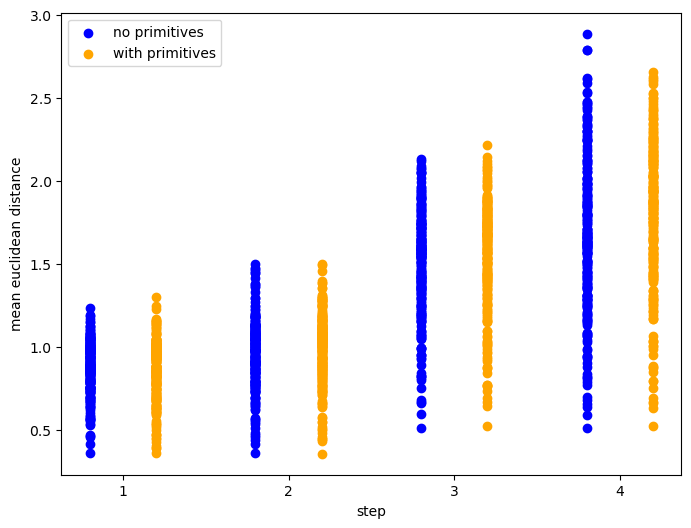

In [188]:
## plot distances between representations across steps for each model
plt.rcParams['figure.figsize'] = 8, 6
plt.scatter(np.ones(len(avg_dists[:,0]))*(0.8), avg_dists[:,0], color='blue', label = 'no primitives')
plt.scatter(np.ones(len(avg_dists_p[:,0]))*(1.2), avg_dists_p[:,0], color='orange', label = 'with primitives')
for h in range(1,4):
    plt.scatter(np.ones(len(avg_dists[:,h]))*(h+ 0.8), avg_dists[:,h], color='blue')
    plt.scatter(np.ones(len(avg_dists_p[:,h]))*(h+1.2), avg_dists_p[:,h], color='orange')
plt.xticks(np.arange(1,5))
plt.xlabel('step')
plt.ylabel('mean euclidean distance')
plt.legend()

In [196]:
statistics = []
pvalues = []
steps = []
for h in range(4):
    steps.append('Step: ' + str(h+1))
    res = scipy.stats.wilcoxon(avg_dists[:,h], avg_dists_p[:,h])
    statistics.append(res[0])
    pvalues.append(res[1])
    
pd.DataFrame({'step':steps, 'statistic': statistics, 'p value': pvalues})

,step,statistic,p value
0,Step: 1,11485.0,6.579082e-04
1,Step: 2,7476.0,3.097465e-12
2,Step: 3,6712.0,1.964400e-14
3,Step: 4,3507.0,8.250848e-26


In [223]:
statistics = []
pvalues = []
steps = []
for h in range(4):
    steps.append('Step: ' + str(h+1))
    res = scipy.stats.ttest_rel(avg_dists[:,h], avg_dists_p[:,h])
    statistics.append(res[0])
    pvalues.append(res[1])
    
pd.DataFrame({'step':steps, 'statistic': statistics, 'p value': pvalues})

,step,statistic,p value
0,Step: 1,2.142751,3.311473e-02
1,Step: 2,-5.428608,1.360623e-07
2,Step: 3,-4.680585,4.728197e-06
3,Step: 4,-11.934631,3.309098e-26


## ii) Orthogonality

In [182]:
### PS functions: 
#     PS: the cosine angle of the coding directions between contexts....

def dot_score(d, i, j):
    """ Dot product between cols i and j in distance matrix d """
    return np.dot(d[:,i], d[:,j])/np.linalg.norm(d[:,i])/np.linalg.norm(d[:,j])

def PS_same_init(d):
    """ PS score for contexts with same init value """
    ps_scores = []
    for q in range(4):
        ps =[]
        for i in range(4*q, 4*q + 4):
            for j in range(4*q, 4*q + 4):
                if i!=j:
                    ps.append(dot_score(d, i, j))
        ps_scores.append(np.mean(ps))
    return np.mean(ps_scores)

def PS_same_last(d):
    """ PS score for contexts with same second value """
    ps_scores = []
    for q in range(4):
        ps =[]
        idxs = [4*k + q for k in range(4)]
        for i in idxs:
            for j in idxs:
                if i!=j:
                    ps.append(dot_score(d, i, j))
        ps_scores.append(np.mean(ps))
    return np.mean(ps_scores)


def PS_inter_init(d):
    """ PS score for contexts with different init value """
    inter_ps = []
    for s in range(4):
        inits = np.arange(4*s, 4*s + 4) # indices of contexts with same initial symbol
        other_inits = [x for x in np.arange(16) if x not in inits] # indices of contexts with diff initial symbol
        ps = []
        for i in inits:
            for j in other_inits:
                ps.append(dot_score(d, i, j))
        inter_ps.append(np.mean(ps))
    return np.mean(inter_ps)

def PS_ind(d):
    """ avg PS score between all contexts """
    ps_scores = []
    for i in range(16):
        ps =[]
        for j in range(16):
            if i!=j:
                ps.append(dot_score(d, i, j))
        ps_scores.append(np.mean(ps))
    return np.mean(ps_scores)

def PS_diff(d):
    """ avg PS score between completely different contexts """
    ps_scores = []
    for i in range(16):
        ps =[]
        init_idx = math.floor(i/4)
        same_init_idx = list(range(init_idx, 4*init_idx))
        last_idx = i%4
        same_last_idx = [4*k + last_idx for k in range(4)]
        all_same = [i] + same_last_idx + same_init_idx
        diff_idx = [q for q in np.arange(16) if q not in all_same]
        for j in diff_idx:
            ps.append(dot_score(d, i, j))
        ps_scores.append(np.mean(ps))
    return np.mean(ps_scores)



In [183]:
for p in range(3):
    for t in range(4):
            print('step ', t, ': ', scipy.stats.wilcoxon(list(map(funcs[p], dms_p[t])), list(map(funcs[p], dms[t]))), '\n')


step  0 :  WilcoxonResult(statistic=585.0, pvalue=0.23129344790121154) 

step  1 :  WilcoxonResult(statistic=597.5, pvalue=0.8774155902380378) 

step  2 :  WilcoxonResult(statistic=2032.0, pvalue=3.204273826857639e-32) 

step  3 :  WilcoxonResult(statistic=4335.0, pvalue=1.5495751509962182e-22) 

step  0 :  WilcoxonResult(statistic=11356.0, pvalue=0.0004294172052803739) 

step  1 :  WilcoxonResult(statistic=12919.0, pvalue=0.03310904591860419) 

step  2 :  WilcoxonResult(statistic=6701.0, pvalue=1.82031051476317e-14) 

step  3 :  WilcoxonResult(statistic=6772.0, pvalue=2.971463941497923e-14) 

step  0 :  WilcoxonResult(statistic=9908.0, pvalue=1.512679268627281e-06) 

step  1 :  WilcoxonResult(statistic=13611.0, pvalue=0.12974526720382984) 

step  2 :  WilcoxonResult(statistic=2709.0, pvalue=3.469826487268818e-29) 

step  3 :  WilcoxonResult(statistic=3561.0, pvalue=1.3712619920399377e-25) 



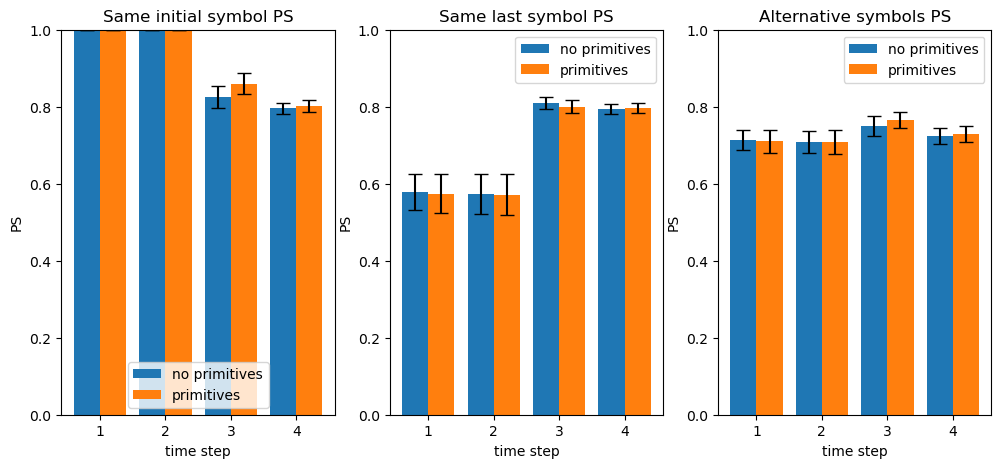

In [222]:
funcs = [PS_same_init, PS_same_last, PS_diff]
titles = ['Same initial symbol', 'Same last symbol', 'Alternative symbols']

plt.rcParams['figure.figsize'] = 12, 5
fig, axs = plt.subplots(1,3)


for p in range(3):
    x = np.arange(1,5)

    PS_p = [np.mean(list(map(funcs[p], dms_p[t]))) for t in range(4)]
    std_p = [np.std(list(map(funcs[p], dms_p[t]))) for t in range(4)]
    PS_np = [np.mean(list(map(funcs[p], dms[t]))) for t in range(4)]
    std_np = [np.std(list(map(funcs[p], dms[t]))) for t in range(4)]
    axs[p].bar(x-0.2, PS_np, yerr = std_np, width = 0.4, capsize=5, label = 'no primitives')
    axs[p].bar(x+0.2, PS_p, yerr = std_p, width = 0.4, capsize=5, label = 'primitives')
    axs[p].set_xticks(x)
    axs[p].set_xlabel('time step')
    axs[p].set_ylabel('PS')
    axs[p].set_ylim(0,1)
    axs[p].title.set_text(titles[p]+' PS')
    axs[p].legend()



In [204]:
p = 2
statistics = []
pvalues = []
steps = []
for t in range(4):
    steps.append('Step: ' + str(t+1))
    res = scipy.stats.wilcoxon(list(map(funcs[p], dms_p[t])), list(map(funcs[p], dms[t])))
    statistics.append(res[0])
    pvalues.append(res[1])
    
pd.DataFrame({'step':steps, 'statistic': statistics, 'p value': pvalues})

,step,statistic,p value
0,Step: 1,9908.0,1.512679e-06
1,Step: 2,13611.0,1.297453e-01
2,Step: 3,2709.0,3.469826e-29
3,Step: 4,3561.0,1.371262e-25


In [185]:
p = 0






print('\n same init --------- ')
for t in range(4):
    print('step ', t, ': ', scipy.stats.wilcoxon(list(map(funcs[p], dms_p[t])), list(map(funcs[p], dms[t]))), '\n')
    print('step ', t, ': ', scipy.stats.ttest_ind(list(map(funcs[p], dms_p[t])), list(map(funcs[p], dms[t]))), '\n')

p = 1
print('\n same last --------- ')
for t in range(4):
    print('step ', t, ': ', scipy.stats.wilcoxon(list(map(funcs[p], dms_p[t])), list(map(funcs[p], dms[t]))), '\n')
    print('step ', t, ': ', scipy.stats.ttest_ind(list(map(funcs[p], dms_p[t])), list(map(funcs[p], dms[t]))), '\n')

p = 2
print('\n diff all --------- ')
for t in range(4):
    print('step ', t, ': ', scipy.stats.wilcoxon(list(map(funcs[p], dms_p[t])), list(map(funcs[p], dms[t]))), '\n')
    print('step ', t, ': ', scipy.stats.ttest_ind(list(map(funcs[p], dms_p[t])), list(map(funcs[p], dms[t]))), '\n')



 same init --------- 
step  0 :  WilcoxonResult(statistic=585.0, pvalue=0.23129344790121154) 

step  0 :  Ttest_indResult(statistic=0.0, pvalue=1.0) 

step  1 :  WilcoxonResult(statistic=597.5, pvalue=0.8774155902380378) 

step  1 :  Ttest_indResult(statistic=0.0, pvalue=1.0) 

step  2 :  WilcoxonResult(statistic=2032.0, pvalue=3.204273826857639e-32) 

step  2 :  Ttest_indResult(statistic=13.542633130984921, pvalue=9.714548545538597e-36) 

step  3 :  WilcoxonResult(statistic=4335.0, pvalue=1.5495751509962182e-22) 

step  3 :  Ttest_indResult(statistic=4.658858088123413, pvalue=4.098268500755402e-06) 


 same last --------- 
step  0 :  WilcoxonResult(statistic=11356.0, pvalue=0.0004294172052803739) 

step  0 :  Ttest_indResult(statistic=-0.9354167200204679, pvalue=0.35003247189575937) 

step  1 :  WilcoxonResult(statistic=12919.0, pvalue=0.03310904591860419) 

step  1 :  Ttest_indResult(statistic=-0.1678816220272918, pvalue=0.8667453936430458) 

step  2 :  WilcoxonResult(statistic=6701

# Visualisation

In [165]:
m = 10

In [166]:
mods1 = res1['mods']
cue_dicts1 = res1['cue_dicts']
testseq = generate_trials(ops, all_syms, all_syms)
testseq = change_dict(testseq, cue_dicts1[m])
train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
hiddens1, trials1 = get_reps(mods1[m], [testset], hidden_size)
distmats = []
for h in range(4):
    first_hid = np.array([hid[h,:] for hid in hiddens1])
    dm = np.array(first_hid)
    distmats.append(euclidean_distances(dm))

mods2 = res1['mods_p']
cue_dicts2 = res1['cue_dicts']
testseq = generate_trials(ops, all_syms, all_syms)
testseq = change_dict(testseq, cue_dicts2[m])
train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
hiddens2, trials2 = get_reps(mods2[m], [testset], hidden_size)
distmats_p = []
for h in range(4):
    first_hid = np.array([hid[h,:] for hid in hiddens2])
    dm = np.array(first_hid)
    distmats_p.append(euclidean_distances(dm))

print(cue_dicts1[m])

{'A': 4, 'B': 6, 'C': 10, 'D': 11}


In [145]:
dms[0][0].shape

(16, 16)

In [156]:
distmats_p = []
distmats = []
for i in range(4):
    distmats.append(np.array(dms[i]).mean(axis=0))
    distmats_p.append(np.array(dms_p[i]).mean(axis=0))

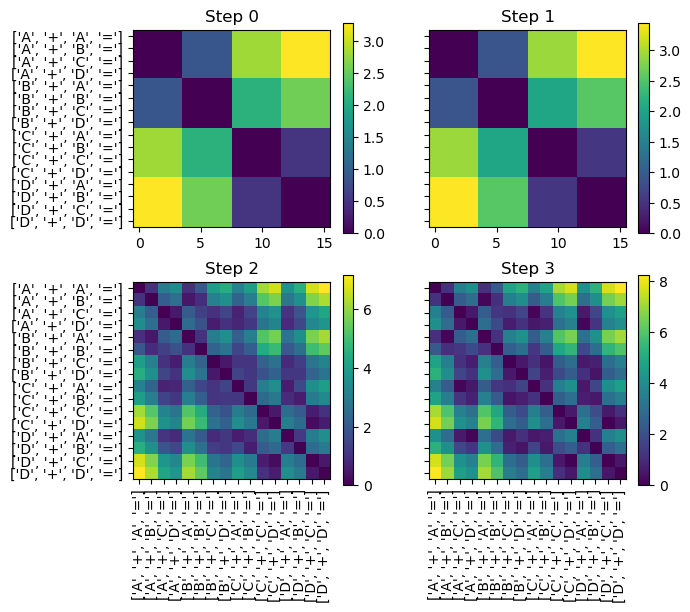

In [220]:
plt.rcParams['figure.figsize'] = 7, 6
fig, axs = plt.subplots(2,2, sharey=True)
for i in range(4):
    ax = axs[math.floor(i/2), i%2]
    g = ax.imshow(distmats[i])
    g1 = ax.set_yticks(np.arange(len(trials)), labels=trials, rotation=0)
    ax.title.set_text('Step '+str(i))
    fig.colorbar(g)
    if i/2 > 0.9:
        g1 = ax.set_xticks(np.arange(len(trials)), labels=trials, rotation=90)
    



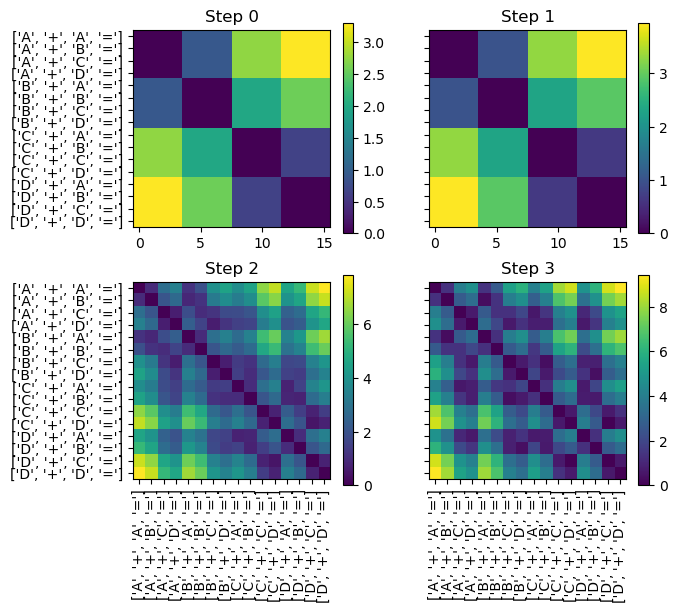

In [219]:
plt.rcParams['figure.figsize'] = 7, 6
fig, axs = plt.subplots(2,2, sharey=True)
for i in range(4):
    ax = axs[math.floor(i/2), i%2]
    g = ax.imshow(distmats_p[i])
    g1 = ax.set_yticks(np.arange(len(trials)), labels=trials, rotation=0)
    ax.title.set_text('Step '+str(i))
    fig.colorbar(g)
    if i/2 > 0.9:
        g1 = ax.set_xticks(np.arange(len(trials)), labels=trials, rotation=90)
        



In [129]:
colors2 = ['green', 'blue', 'orange', 'red']*4
colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4

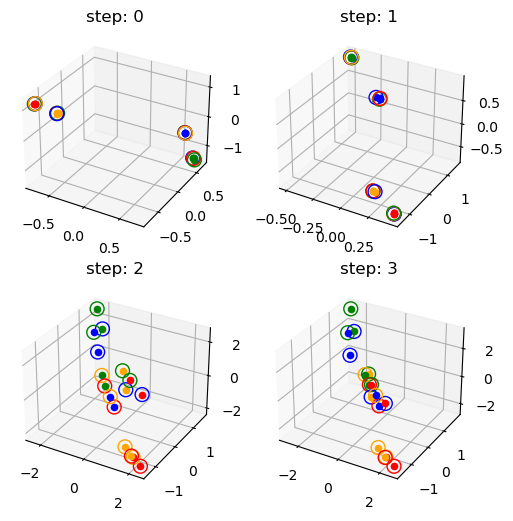

In [214]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2, subplot_kw=dict(projection='3d'))

for j, dist in enumerate(distmats):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=3)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(trials)):
        ax.scatter(X_transform[i,0], X_transform[i,1],X_transform[i,2], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1],X_transform[i,2], s=100, facecolors='none', edgecolors=colors2[i])

    
    

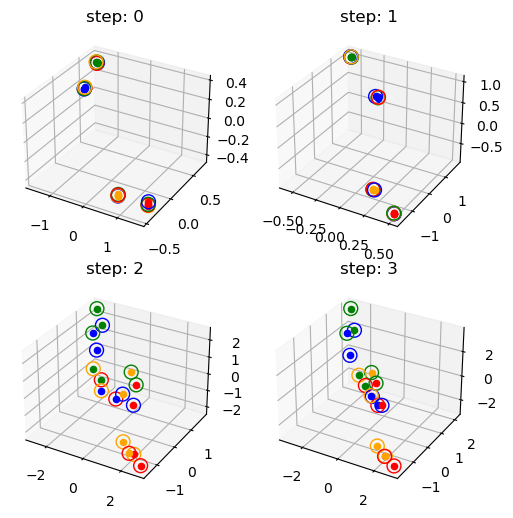

In [206]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2, subplot_kw=dict(projection='3d'))

for j, dist in enumerate(distmats_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=3)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(trials)):
        ax.scatter(X_transform[i,0], X_transform[i,1],X_transform[i,2], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1],X_transform[i,2], s=100, facecolors='none', edgecolors=colors2[i])

    
    